# Kernel density estimation (KDE) challenge


The task is to generate parameters of the Gaussian mixture model that best describes samples from an intractable target distributions. Target distribution samples are generated by pass unit Gaussian samples through a small multi-layer perceptron transformation. 


### Table of contents
1. [Run LLM-innovation loop](#loop)
2. [Visualise KDE instances](#visualise)

In [2]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt


import template

<a id="1D"></a>
## 1. Example 1D challenge target distribution samples

In [3]:
seed = 1234
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 20
z = rng_samps.normal(size=(num_samples, 1))

x = template.generate_samples(rng_params, z)

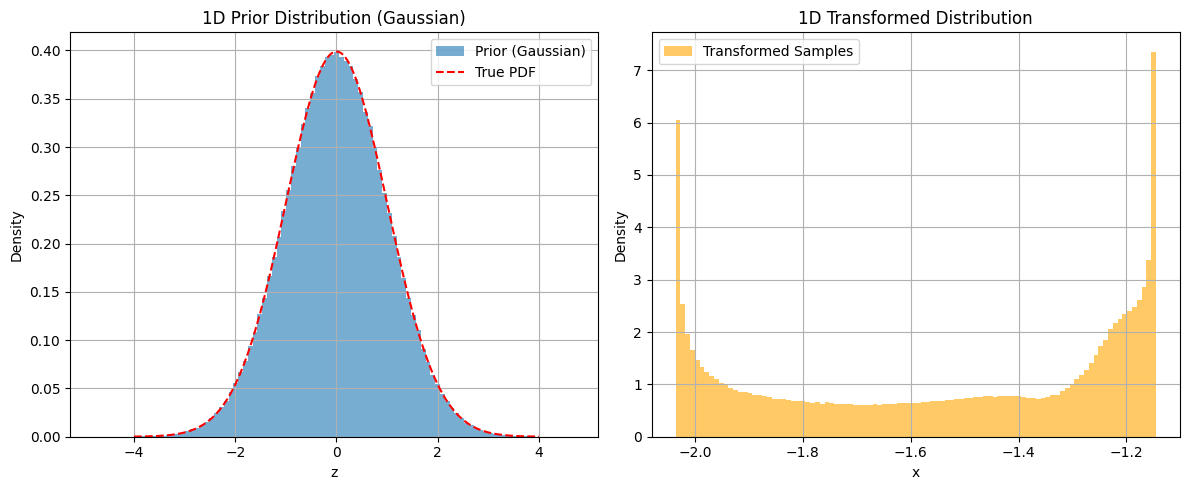

In [4]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist(z, bins=100, density=True, alpha=0.6, label="Prior (Gaussian)")
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'r--', label="True PDF")
plt.title("1D Prior Distribution (Gaussian)")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist(x, bins=100, density=True, alpha=0.6, label="Transformed Samples", color="orange")
plt.title("1D Transformed Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<a id="2D"></a>
## 2. Example 2D challenge target distribution samples

In [5]:
seed = 12349
rng_params = np.random.default_rng(seed)
rng_samps = np.random.default_rng(seed + 1)

num_samples = 2 ** 20
z = rng_samps.normal(size=(num_samples, 2))

x = template.generate_samples(rng_params, z)

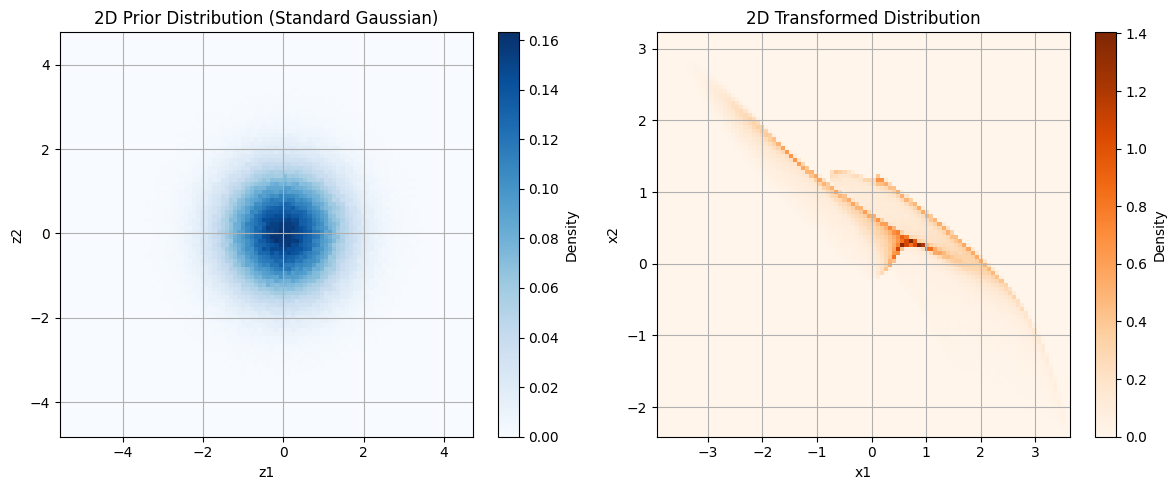

In [6]:
# Plot
plt.figure(figsize=(12, 5))

# Prior
plt.subplot(1, 2, 1)
plt.hist2d(z[:, 0], z[:, 1], bins=100, density=True, cmap='Blues')
plt.colorbar(label="Density")
plt.title("2D Prior Distribution (Standard Gaussian)")
plt.xlabel("z1")
plt.ylabel("z2")
#plt.axis("equal")
plt.grid(True)

# Transformed
plt.subplot(1, 2, 2)
plt.hist2d(x[:, 0], x[:, 1], bins=100, density=True, cmap='Oranges')
plt.colorbar(label="Density")
plt.title("2D Transformed Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
#plt.axis("equal")
plt.grid(True)

plt.tight_layout()
plt.show()

<a id="visual"></a>
## 3. Visualising simple baseline heuristics for KDE

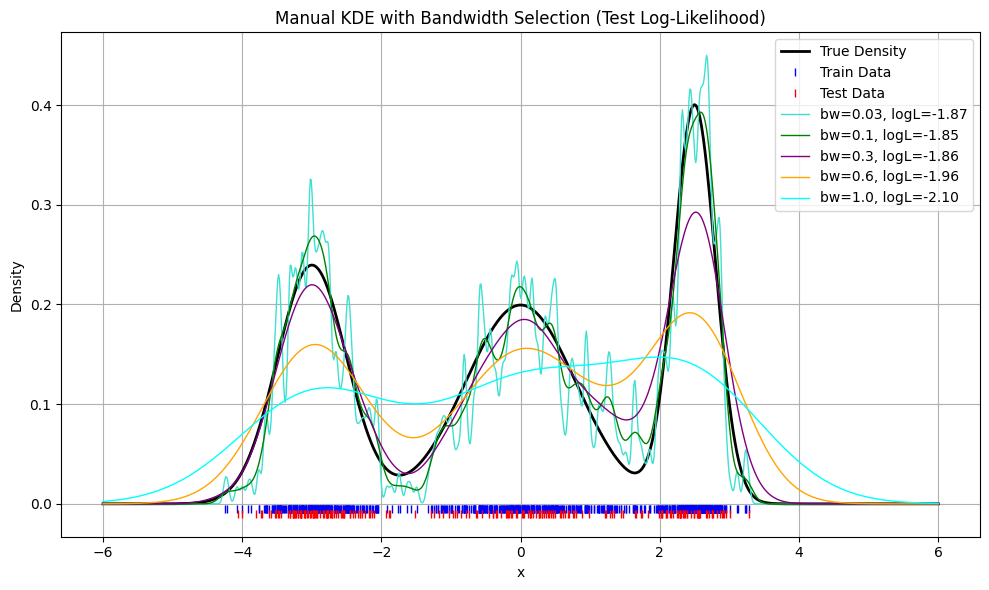

In [7]:
# Set seed for reproducibility
np.random.seed(42)

# Generate multimodal data from a GMM
def sample_gmm(n_samples=1000):
    means = [-3, 0, 2.5]
    stds = [0.5, 0.8, 0.3]
    weights = [0.3, 0.4, 0.3]
    components = np.random.choice(len(means), size=n_samples, p=weights)
    samples = np.random.normal(loc=np.array(means)[components],
                               scale=np.array(stds)[components])
    return samples

# True GMM density
def true_gmm_pdf(x):
    means = [-3, 0, 2.5]
    stds = [0.5, 0.8, 0.3]
    weights = [0.3, 0.4, 0.3]
    return sum(w * norm.pdf(x, m, s) for w, m, s in zip(weights, means, stds))

# Manual KDE
def kde_estimate(x_eval, data, bandwidth):
    n = len(data)
    kernels = np.exp(-0.5 * ((x_eval[:, None] - data[None, :]) / bandwidth)**2)
    return np.mean(kernels, axis=1) / (bandwidth * np.sqrt(2 * np.pi))

# Log-likelihood on test data
def log_likelihood_kde(test_data, train_data, bandwidth):
    n = len(train_data)
    densities = np.array([
        np.mean(norm.pdf(x, train_data, bandwidth))
        for x in test_data
    ])
    return np.mean(np.log(densities + 1e-12))  # add epsilon for stability

# Sample data and split into train/test
data = sample_gmm(1000)
np.random.shuffle(data)
split = int(0.8 * len(data))
train_data = data[:split]
test_data = data[split:]

# Evaluation grid
x_grid = np.linspace(-6, 6, 1000)

# Plot setup
plt.figure(figsize=(10, 6))

# Plot true density
plt.plot(x_grid, true_gmm_pdf(x_grid), color='k', lw=2, label='True Density')

# Plot train/test samples
plt.plot(train_data, np.full_like(train_data, -0.005), '|', color='blue', label='Train Data')
plt.plot(test_data, np.full_like(test_data, -0.01), '|', color='red', label='Test Data')

# Bandwidths to try
bandwidths = [0.03, 0.1, 0.3, 0.6, 1.0]
colors = ['turquoise', 'green', 'purple', 'orange', 'cyan']

# Plot KDEs and compute log-likelihood
for bw, color in zip(bandwidths, colors):
    kde_vals = kde_estimate(x_grid, train_data, bw)
    ll = log_likelihood_kde(test_data, train_data, bw)
    plt.plot(x_grid, kde_vals, color=color, lw=1, label=f'bw={bw}, logL={ll:.2f}', alpha=1)

# Finalize plot
plt.title("Manual KDE with Bandwidth Selection (Test Log-Likelihood)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
bandwidths = np.linspace(0.05, 1.5, 100)
log_likelihoods = np.array([log_likelihood_kde(test_data, train_data, bw) for bw in bandwidths])

std_dev = train_data.std(ddof=1)
n = train_data.shape[0]

# Compute interquartile range (IQR) for Silverman's alternative version
q75, q25 = np.percentile(train_data, [75, 25])
iqr = q75 - q25

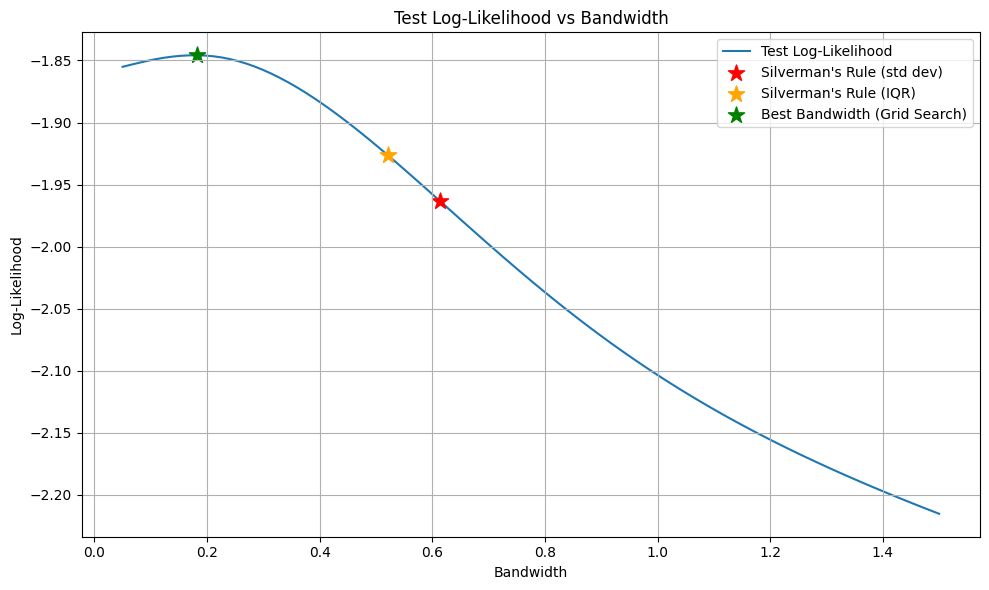

In [16]:
# Silverman's rule with IQR adjustment (as per some implementations)
silverman_bw = 1.06 * std_dev * n ** (-1 / 5)
silverman_iqr_bw = 0.9 * min(std_dev, iqr / 1.34) * n ** (-1 / 5)

# Find the best bandwidth from the grid search
best_bw_idx = np.argmax(log_likelihoods)
best_bw = bandwidths[best_bw_idx]
best_ll = log_likelihoods[best_bw_idx]

# Plotting
fig, ax2 = plt.subplots(figsize=(10, 6))

# Bottom plot: Log-likelihood vs bandwidth
ax2.plot(bandwidths, log_likelihoods, label='Test Log-Likelihood', zorder=-2)

# Add scatter points for Silverman's rules and best bw
ax2.scatter([silverman_bw], 
            [log_likelihood_kde(test_data, train_data, silverman_bw)],
            color='red', marker='*', s=150, label="Silverman's Rule (std dev)")

ax2.scatter([silverman_iqr_bw], 
            [log_likelihood_kde(test_data, train_data, silverman_iqr_bw)],
            color='orange', marker='*', s=150, label="Silverman's Rule (IQR)")

ax2.scatter([best_bw], [best_ll], color='green', marker='*', s=150, label='Best Bandwidth (Grid Search)')

ax2.set_title("Test Log-Likelihood vs Bandwidth")
ax2.set_xlabel("Bandwidth")
ax2.set_ylabel("Log-Likelihood")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()